In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(684288, 828)
(684288, 1)
validation
(113488, 828)
(113488, 1)
test
(56512, 828)
(56512, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/69 [..............................] - ETA: 1:52 - loss: 0.0474 - STD: 2.5360e-04 - MAE: 0.1990

 4/69 [>.............................] - ETA: 17s - loss: 0.0255 - STD: 3.2714e-04 - MAE: 0.1250 

 7/69 [==>...........................] - ETA: 8s - loss: 0.0254 - STD: 2.8445e-04 - MAE: 0.1245 

 8/69 [==>...........................] - ETA: 8s - loss: 0.0249 - STD: 2.7824e-04 - MAE: 0.1228

 9/69 [==>...........................] - ETA: 7s - loss: 0.0241 - STD: 2.7574e-04 - MAE: 0.1200

10/69 [===>..........................] - ETA: 7s - loss: 0.0231 - STD: 2.7594e-04 - MAE: 0.1167

11/69 [===>..........................] - ETA: 7s - loss: 0.0220 - STD: 2.7857e-04 - MAE: 0.1134

12/69 [====>.........................] - ETA: 6s - loss: 0.0210 - STD: 2.8277e-04 - MAE: 0.1107

13/69 [====>.........................] - ETA: 6s - loss: 0.0203 - STD: 2.8806e-04 - MAE: 0.1091

14/69 [=====>........................] - ETA: 6s - loss: 0.0198 - STD: 2.9364e-04 - MAE: 0.1085

15/69 [=====>........................] - ETA: 6s - loss: 0.0195 - STD: 2.9971e-04 - MAE: 0.1083

16/69 [=====>........................] - ETA: 6s - loss: 0.0192 - STD: 3.0609e-04 - MAE: 0.1082

17/69 [======>.......................] - ETA: 6s - loss: 0.0188 - STD: 3.1284e-04 - MAE: 0.1076

18/69 [======>.......................] - ETA: 5s - loss: 0.0184 - STD: 3.1923e-04 - MAE: 0.1067

19/69 [=======>......................] - ETA: 5s - loss: 0.0181 - STD: 3.2556e-04 - MAE: 0.1056

20/69 [=======>......................] - ETA: 5s - loss: 0.0177 - STD: 3.3094e-04 - MAE: 0.1043

21/69 [========>.....................] - ETA: 5s - loss: 0.0174 - STD: 3.3584e-04 - MAE: 0.1031

22/69 [========>.....................] - ETA: 5s - loss: 0.0171 - STD: 3.4034e-04 - MAE: 0.1021

23/69 [=========>....................] - ETA: 5s - loss: 0.0169 - STD: 3.4461e-04 - MAE: 0.1012

24/69 [=========>....................] - ETA: 5s - loss: 0.0167 - STD: 3.4880e-04 - MAE: 0.1003

25/69 [=========>....................] - ETA: 5s - loss: 0.0165 - STD: 3.5313e-04 - MAE: 0.0996

26/69 [==========>...................] - ETA: 4s - loss: 0.0164 - STD: 3.5816e-04 - MAE: 0.0989

27/69 [==========>...................] - ETA: 4s - loss: 0.0162 - STD: 3.6411e-04 - MAE: 0.0982

28/69 [===========>..................] - ETA: 4s - loss: 0.0160 - STD: 3.7061e-04 - MAE: 0.0975

29/69 [===========>..................] - ETA: 4s - loss: 0.0158 - STD: 3.7821e-04 - MAE: 0.0969

30/69 [============>.................] - ETA: 4s - loss: 0.0157 - STD: 3.8642e-04 - MAE: 0.0964

31/69 [============>.................] - ETA: 4s - loss: 0.0155 - STD: 3.9532e-04 - MAE: 0.0960

32/69 [============>.................] - ETA: 4s - loss: 0.0154 - STD: 4.0485e-04 - MAE: 0.0957

33/69 [=============>................] - ETA: 4s - loss: 0.0153 - STD: 4.1477e-04 - MAE: 0.0954

34/69 [=============>................] - ETA: 3s - loss: 0.0151 - STD: 4.2520e-04 - MAE: 0.0952

35/69 [==============>...............] - ETA: 3s - loss: 0.0150 - STD: 4.3570e-04 - MAE: 0.0950

36/69 [==============>...............] - ETA: 3s - loss: 0.0149 - STD: 4.4625e-04 - MAE: 0.0947

37/69 [===============>..............] - ETA: 3s - loss: 0.0148 - STD: 4.5660e-04 - MAE: 0.0945

38/69 [===============>..............] - ETA: 3s - loss: 0.0147 - STD: 4.6692e-04 - MAE: 0.0942

39/69 [===============>..............] - ETA: 3s - loss: 0.0146 - STD: 4.7698e-04 - MAE: 0.0939

40/69 [================>.............] - ETA: 3s - loss: 0.0145 - STD: 4.8706e-04 - MAE: 0.0935

41/69 [================>.............] - ETA: 3s - loss: 0.0144 - STD: 4.9699e-04 - MAE: 0.0932

42/69 [=================>............] - ETA: 3s - loss: 0.0144 - STD: 5.0720e-04 - MAE: 0.0929

43/69 [=================>............] - ETA: 2s - loss: 0.0143 - STD: 5.1776e-04 - MAE: 0.0926

44/69 [==================>...........] - ETA: 2s - loss: 0.0142 - STD: 5.2858e-04 - MAE: 0.0923

45/69 [==================>...........] - ETA: 2s - loss: 0.0141 - STD: 5.3992e-04 - MAE: 0.0921

46/69 [===================>..........] - ETA: 2s - loss: 0.0141 - STD: 5.5198e-04 - MAE: 0.0918

47/69 [===================>..........] - ETA: 2s - loss: 0.0140 - STD: 5.6496e-04 - MAE: 0.0916

48/69 [===================>..........] - ETA: 2s - loss: 0.0139 - STD: 5.7873e-04 - MAE: 0.0914

49/69 [====================>.........] - ETA: 2s - loss: 0.0139 - STD: 5.9329e-04 - MAE: 0.0912

50/69 [====================>.........] - ETA: 2s - loss: 0.0138 - STD: 6.0879e-04 - MAE: 0.0910

51/69 [=====================>........] - ETA: 2s - loss: 0.0138 - STD: 6.2501e-04 - MAE: 0.0909

52/69 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 6.4190e-04 - MAE: 0.0908

53/69 [======================>.......] - ETA: 1s - loss: 0.0136 - STD: 6.5915e-04 - MAE: 0.0906

54/69 [======================>.......] - ETA: 1s - loss: 0.0136 - STD: 6.7709e-04 - MAE: 0.0905

55/69 [======================>.......] - ETA: 1s - loss: 0.0135 - STD: 6.9530e-04 - MAE: 0.0903

56/69 [=======================>......] - ETA: 1s - loss: 0.0135 - STD: 7.1425e-04 - MAE: 0.0902

57/69 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 7.3331e-04 - MAE: 0.0900

58/69 [========================>.....] - ETA: 1s - loss: 0.0134 - STD: 7.5295e-04 - MAE: 0.0898

59/69 [========================>.....] - ETA: 1s - loss: 0.0134 - STD: 7.7377e-04 - MAE: 0.0897

60/69 [=========================>....] - ETA: 1s - loss: 0.0133 - STD: 7.9512e-04 - MAE: 0.0895

61/69 [=========================>....] - ETA: 0s - loss: 0.0133 - STD: 8.1774e-04 - MAE: 0.0894

62/69 [=========================>....] - ETA: 0s - loss: 0.0132 - STD: 8.4182e-04 - MAE: 0.0893

63/69 [==========================>...] - ETA: 0s - loss: 0.0132 - STD: 8.6688e-04 - MAE: 0.0891

64/69 [==========================>...] - ETA: 0s - loss: 0.0131 - STD: 8.9312e-04 - MAE: 0.0890

65/69 [===========================>..] - ETA: 0s - loss: 0.0131 - STD: 9.2173e-04 - MAE: 0.0889

66/69 [===========================>..] - ETA: 0s - loss: 0.0131 - STD: 9.5162e-04 - MAE: 0.0888

67/69 [============================>.] - ETA: 0s - loss: 0.0130 - STD: 9.8342e-04 - MAE: 0.0887

68/69 [============================>.] - ETA: 0s - loss: 0.0130 - STD: 0.0010 - MAE: 0.0886    

69/69 [==============================] - ETA: 0s - loss: 0.0130 - STD: 0.0011 - MAE: 0.0885

69/69 [==============================] - 10s 123ms/step - loss: 0.0130 - STD: 0.0011 - MAE: 0.0885 - val_loss: 0.0122 - val_STD: 0.0030 - val_MAE: 0.0853


Epoch 2/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0107 - STD: 0.0037 - MAE: 0.0819

 2/69 [..............................] - ETA: 7s - loss: 0.0108 - STD: 0.0037 - MAE: 0.0819

 3/69 [>.............................] - ETA: 7s - loss: 0.0107 - STD: 0.0038 - MAE: 0.0813

 5/69 [=>............................] - ETA: 6s - loss: 0.0107 - STD: 0.0040 - MAE: 0.0809

 6/69 [=>............................] - ETA: 6s - loss: 0.0107 - STD: 0.0042 - MAE: 0.0809

 7/69 [==>...........................] - ETA: 6s - loss: 0.0106 - STD: 0.0043 - MAE: 0.0807

 8/69 [==>...........................] - ETA: 6s - loss: 0.0106 - STD: 0.0045 - MAE: 0.0807

 9/69 [==>...........................] - ETA: 6s - loss: 0.0106 - STD: 0.0046 - MAE: 0.0807

10/69 [===>..........................] - ETA: 5s - loss: 0.0106 - STD: 0.0048 - MAE: 0.0806

11/69 [===>..........................] - ETA: 5s - loss: 0.0106 - STD: 0.0049 - MAE: 0.0806

12/69 [====>.........................] - ETA: 5s - loss: 0.0105 - STD: 0.0051 - MAE: 0.0806

13/69 [====>.........................] - ETA: 5s - loss: 0.0105 - STD: 0.0053 - MAE: 0.0805

14/69 [=====>........................] - ETA: 5s - loss: 0.0105 - STD: 0.0055 - MAE: 0.0804

15/69 [=====>........................] - ETA: 5s - loss: 0.0104 - STD: 0.0058 - MAE: 0.0804

16/69 [=====>........................] - ETA: 5s - loss: 0.0104 - STD: 0.0060 - MAE: 0.0804

17/69 [======>.......................] - ETA: 5s - loss: 0.0104 - STD: 0.0062 - MAE: 0.0803

18/69 [======>.......................] - ETA: 5s - loss: 0.0104 - STD: 0.0065 - MAE: 0.0803

19/69 [=======>......................] - ETA: 5s - loss: 0.0104 - STD: 0.0068 - MAE: 0.0802

20/69 [=======>......................] - ETA: 5s - loss: 0.0103 - STD: 0.0070 - MAE: 0.0801

21/69 [========>.....................] - ETA: 4s - loss: 0.0103 - STD: 0.0073 - MAE: 0.0800

22/69 [========>.....................] - ETA: 4s - loss: 0.0103 - STD: 0.0077 - MAE: 0.0799

23/69 [=========>....................] - ETA: 4s - loss: 0.0102 - STD: 0.0080 - MAE: 0.0798

24/69 [=========>....................] - ETA: 4s - loss: 0.0102 - STD: 0.0084 - MAE: 0.0796

25/69 [=========>....................] - ETA: 4s - loss: 0.0102 - STD: 0.0087 - MAE: 0.0795

26/69 [==========>...................] - ETA: 4s - loss: 0.0101 - STD: 0.0091 - MAE: 0.0795

27/69 [==========>...................] - ETA: 4s - loss: 0.0101 - STD: 0.0096 - MAE: 0.0793

28/69 [===========>..................] - ETA: 4s - loss: 0.0101 - STD: 0.0100 - MAE: 0.0792

29/69 [===========>..................] - ETA: 4s - loss: 0.0100 - STD: 0.0105 - MAE: 0.0791

30/69 [============>.................] - ETA: 4s - loss: 0.0100 - STD: 0.0110 - MAE: 0.0790

31/69 [============>.................] - ETA: 3s - loss: 0.0100 - STD: 0.0115 - MAE: 0.0789

32/69 [============>.................] - ETA: 3s - loss: 0.0099 - STD: 0.0120 - MAE: 0.0788

33/69 [=============>................] - ETA: 3s - loss: 0.0099 - STD: 0.0126 - MAE: 0.0786

34/69 [=============>................] - ETA: 3s - loss: 0.0099 - STD: 0.0131 - MAE: 0.0785

35/69 [==============>...............] - ETA: 3s - loss: 0.0098 - STD: 0.0137 - MAE: 0.0784

36/69 [==============>...............] - ETA: 3s - loss: 0.0098 - STD: 0.0143 - MAE: 0.0782

37/69 [===============>..............] - ETA: 3s - loss: 0.0098 - STD: 0.0150 - MAE: 0.0781

38/69 [===============>..............] - ETA: 3s - loss: 0.0097 - STD: 0.0156 - MAE: 0.0780

39/69 [===============>..............] - ETA: 3s - loss: 0.0097 - STD: 0.0163 - MAE: 0.0779

40/69 [================>.............] - ETA: 3s - loss: 0.0097 - STD: 0.0169 - MAE: 0.0777

41/69 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 0.0176 - MAE: 0.0776

42/69 [=================>............] - ETA: 2s - loss: 0.0096 - STD: 0.0182 - MAE: 0.0774

43/69 [=================>............] - ETA: 2s - loss: 0.0096 - STD: 0.0189 - MAE: 0.0773

44/69 [==================>...........] - ETA: 2s - loss: 0.0095 - STD: 0.0195 - MAE: 0.0772

45/69 [==================>...........] - ETA: 2s - loss: 0.0095 - STD: 0.0202 - MAE: 0.0771

46/69 [===================>..........] - ETA: 2s - loss: 0.0095 - STD: 0.0208 - MAE: 0.0770

47/69 [===================>..........] - ETA: 2s - loss: 0.0095 - STD: 0.0214 - MAE: 0.0769

48/69 [===================>..........] - ETA: 2s - loss: 0.0094 - STD: 0.0220 - MAE: 0.0767

49/69 [====================>.........] - ETA: 2s - loss: 0.0094 - STD: 0.0226 - MAE: 0.0766

50/69 [====================>.........] - ETA: 1s - loss: 0.0094 - STD: 0.0232 - MAE: 0.0765

51/69 [=====================>........] - ETA: 1s - loss: 0.0094 - STD: 0.0237 - MAE: 0.0764

52/69 [=====================>........] - ETA: 1s - loss: 0.0094 - STD: 0.0242 - MAE: 0.0763

53/69 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0247 - MAE: 0.0762

54/69 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0252 - MAE: 0.0761

55/69 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0256 - MAE: 0.0760

56/69 [=======================>......] - ETA: 1s - loss: 0.0093 - STD: 0.0260 - MAE: 0.0759

57/69 [=======================>......] - ETA: 1s - loss: 0.0092 - STD: 0.0264 - MAE: 0.0758

58/69 [========================>.....] - ETA: 1s - loss: 0.0092 - STD: 0.0268 - MAE: 0.0757

59/69 [========================>.....] - ETA: 1s - loss: 0.0092 - STD: 0.0271 - MAE: 0.0756

60/69 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.0275 - MAE: 0.0755

61/69 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.0278 - MAE: 0.0754

62/69 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0281 - MAE: 0.0753

63/69 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0284 - MAE: 0.0752

64/69 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0287 - MAE: 0.0752

65/69 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0290 - MAE: 0.0751

66/69 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0293 - MAE: 0.0750

67/69 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0296 - MAE: 0.0749

68/69 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0299 - MAE: 0.0748

69/69 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0302 - MAE: 0.0748

69/69 [==============================] - 8s 109ms/step - loss: 0.0090 - STD: 0.0302 - MAE: 0.0748 - val_loss: 0.0092 - val_STD: 0.0431 - val_MAE: 0.0750


Epoch 3/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0075 - STD: 0.0504 - MAE: 0.0679

 2/69 [..............................] - ETA: 7s - loss: 0.0076 - STD: 0.0505 - MAE: 0.0681

 3/69 [>.............................] - ETA: 7s - loss: 0.0075 - STD: 0.0506 - MAE: 0.0679

 4/69 [>.............................] - ETA: 7s - loss: 0.0076 - STD: 0.0507 - MAE: 0.0679

 5/69 [=>............................] - ETA: 7s - loss: 0.0076 - STD: 0.0508 - MAE: 0.0679

 6/69 [=>............................] - ETA: 6s - loss: 0.0076 - STD: 0.0511 - MAE: 0.0678

 7/69 [==>...........................] - ETA: 6s - loss: 0.0076 - STD: 0.0513 - MAE: 0.0678

 8/69 [==>...........................] - ETA: 6s - loss: 0.0076 - STD: 0.0515 - MAE: 0.0678

 9/69 [==>...........................] - ETA: 6s - loss: 0.0075 - STD: 0.0517 - MAE: 0.0677

10/69 [===>..........................] - ETA: 6s - loss: 0.0076 - STD: 0.0518 - MAE: 0.0677

11/69 [===>..........................] - ETA: 6s - loss: 0.0075 - STD: 0.0519 - MAE: 0.0677

12/69 [====>.........................] - ETA: 6s - loss: 0.0075 - STD: 0.0521 - MAE: 0.0676

13/69 [====>.........................] - ETA: 6s - loss: 0.0075 - STD: 0.0521 - MAE: 0.0675

14/69 [=====>........................] - ETA: 6s - loss: 0.0075 - STD: 0.0523 - MAE: 0.0674

15/69 [=====>........................] - ETA: 5s - loss: 0.0075 - STD: 0.0524 - MAE: 0.0673

16/69 [=====>........................] - ETA: 5s - loss: 0.0074 - STD: 0.0524 - MAE: 0.0672

17/69 [======>.......................] - ETA: 5s - loss: 0.0074 - STD: 0.0525 - MAE: 0.0671

18/69 [======>.......................] - ETA: 5s - loss: 0.0074 - STD: 0.0526 - MAE: 0.0670

19/69 [=======>......................] - ETA: 5s - loss: 0.0074 - STD: 0.0528 - MAE: 0.0669

20/69 [=======>......................] - ETA: 5s - loss: 0.0074 - STD: 0.0529 - MAE: 0.0668

21/69 [========>.....................] - ETA: 5s - loss: 0.0074 - STD: 0.0530 - MAE: 0.0667

22/69 [========>.....................] - ETA: 5s - loss: 0.0073 - STD: 0.0532 - MAE: 0.0666

23/69 [=========>....................] - ETA: 5s - loss: 0.0073 - STD: 0.0534 - MAE: 0.0665

24/69 [=========>....................] - ETA: 4s - loss: 0.0073 - STD: 0.0536 - MAE: 0.0664

25/69 [=========>....................] - ETA: 4s - loss: 0.0073 - STD: 0.0538 - MAE: 0.0663

26/69 [==========>...................] - ETA: 4s - loss: 0.0072 - STD: 0.0541 - MAE: 0.0662

27/69 [==========>...................] - ETA: 4s - loss: 0.0072 - STD: 0.0544 - MAE: 0.0661

28/69 [===========>..................] - ETA: 4s - loss: 0.0072 - STD: 0.0546 - MAE: 0.0660

29/69 [===========>..................] - ETA: 4s - loss: 0.0072 - STD: 0.0548 - MAE: 0.0659

30/69 [============>.................] - ETA: 4s - loss: 0.0072 - STD: 0.0551 - MAE: 0.0658

31/69 [============>.................] - ETA: 4s - loss: 0.0072 - STD: 0.0554 - MAE: 0.0657

32/69 [============>.................] - ETA: 4s - loss: 0.0071 - STD: 0.0556 - MAE: 0.0656

33/69 [=============>................] - ETA: 3s - loss: 0.0071 - STD: 0.0558 - MAE: 0.0655

34/69 [=============>................] - ETA: 3s - loss: 0.0071 - STD: 0.0561 - MAE: 0.0654

35/69 [==============>...............] - ETA: 3s - loss: 0.0071 - STD: 0.0563 - MAE: 0.0654

36/69 [==============>...............] - ETA: 3s - loss: 0.0071 - STD: 0.0564 - MAE: 0.0652

37/69 [===============>..............] - ETA: 3s - loss: 0.0071 - STD: 0.0567 - MAE: 0.0651

38/69 [===============>..............] - ETA: 3s - loss: 0.0070 - STD: 0.0569 - MAE: 0.0650

39/69 [===============>..............] - ETA: 3s - loss: 0.0070 - STD: 0.0570 - MAE: 0.0650

40/69 [================>.............] - ETA: 3s - loss: 0.0070 - STD: 0.0572 - MAE: 0.0649

41/69 [================>.............] - ETA: 3s - loss: 0.0070 - STD: 0.0575 - MAE: 0.0648

42/69 [=================>............] - ETA: 2s - loss: 0.0070 - STD: 0.0576 - MAE: 0.0647

43/69 [=================>............] - ETA: 2s - loss: 0.0070 - STD: 0.0577 - MAE: 0.0646

44/69 [==================>...........] - ETA: 2s - loss: 0.0070 - STD: 0.0579 - MAE: 0.0646

46/69 [===================>..........] - ETA: 2s - loss: 0.0070 - STD: 0.0582 - MAE: 0.0645

47/69 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0584 - MAE: 0.0644

48/69 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0585 - MAE: 0.0644

49/69 [====================>.........] - ETA: 2s - loss: 0.0069 - STD: 0.0586 - MAE: 0.0643

50/69 [====================>.........] - ETA: 2s - loss: 0.0069 - STD: 0.0588 - MAE: 0.0642

51/69 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0589 - MAE: 0.0642

52/69 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0591 - MAE: 0.0641

53/69 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0592 - MAE: 0.0641

54/69 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0594 - MAE: 0.0640

55/69 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0594 - MAE: 0.0639

56/69 [=======================>......] - ETA: 1s - loss: 0.0069 - STD: 0.0596 - MAE: 0.0639

57/69 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0597 - MAE: 0.0638

58/69 [========================>.....] - ETA: 1s - loss: 0.0068 - STD: 0.0599 - MAE: 0.0638

59/69 [========================>.....] - ETA: 1s - loss: 0.0068 - STD: 0.0600 - MAE: 0.0637

60/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0601 - MAE: 0.0637

61/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0602 - MAE: 0.0636

62/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0603 - MAE: 0.0635

63/69 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0603 - MAE: 0.0635

64/69 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0604 - MAE: 0.0634

65/69 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0605 - MAE: 0.0634

66/69 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0606 - MAE: 0.0633

67/69 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0607 - MAE: 0.0633

68/69 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0608 - MAE: 0.0632

69/69 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0609 - MAE: 0.0632

69/69 [==============================] - 8s 113ms/step - loss: 0.0067 - STD: 0.0609 - MAE: 0.0632 - val_loss: 0.0071 - val_STD: 0.0686 - val_MAE: 0.0651


Epoch 4/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0062 - STD: 0.0674 - MAE: 0.0599

 2/69 [..............................] - ETA: 7s - loss: 0.0061 - STD: 0.0676 - MAE: 0.0592

 3/69 [>.............................] - ETA: 7s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0592

 4/69 [>.............................] - ETA: 7s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0591

 5/69 [=>............................] - ETA: 6s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0593

 6/69 [=>............................] - ETA: 6s - loss: 0.0061 - STD: 0.0680 - MAE: 0.0592

 7/69 [==>...........................] - ETA: 6s - loss: 0.0061 - STD: 0.0682 - MAE: 0.0593

 8/69 [==>...........................] - ETA: 6s - loss: 0.0061 - STD: 0.0682 - MAE: 0.0593

 9/69 [==>...........................] - ETA: 6s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0592

10/69 [===>..........................] - ETA: 6s - loss: 0.0061 - STD: 0.0677 - MAE: 0.0591

11/69 [===>..........................] - ETA: 6s - loss: 0.0061 - STD: 0.0680 - MAE: 0.0593

12/69 [====>.........................] - ETA: 6s - loss: 0.0061 - STD: 0.0676 - MAE: 0.0591

13/69 [====>.........................] - ETA: 6s - loss: 0.0060 - STD: 0.0675 - MAE: 0.0590

14/69 [=====>........................] - ETA: 5s - loss: 0.0060 - STD: 0.0677 - MAE: 0.0591

15/69 [=====>........................] - ETA: 5s - loss: 0.0060 - STD: 0.0674 - MAE: 0.0591

16/69 [=====>........................] - ETA: 5s - loss: 0.0061 - STD: 0.0676 - MAE: 0.0592

17/69 [======>.......................] - ETA: 5s - loss: 0.0060 - STD: 0.0677 - MAE: 0.0591

18/69 [======>.......................] - ETA: 5s - loss: 0.0060 - STD: 0.0675 - MAE: 0.0590

19/69 [=======>......................] - ETA: 5s - loss: 0.0060 - STD: 0.0678 - MAE: 0.0591

20/69 [=======>......................] - ETA: 5s - loss: 0.0060 - STD: 0.0676 - MAE: 0.0591

21/69 [========>.....................] - ETA: 5s - loss: 0.0060 - STD: 0.0677 - MAE: 0.0590

22/69 [========>.....................] - ETA: 5s - loss: 0.0060 - STD: 0.0679 - MAE: 0.0591

23/69 [=========>....................] - ETA: 4s - loss: 0.0060 - STD: 0.0677 - MAE: 0.0590

24/69 [=========>....................] - ETA: 4s - loss: 0.0060 - STD: 0.0679 - MAE: 0.0591

25/69 [=========>....................] - ETA: 4s - loss: 0.0060 - STD: 0.0679 - MAE: 0.0590

26/69 [==========>...................] - ETA: 4s - loss: 0.0060 - STD: 0.0679 - MAE: 0.0590

27/69 [==========>...................] - ETA: 4s - loss: 0.0060 - STD: 0.0680 - MAE: 0.0590

28/69 [===========>..................] - ETA: 4s - loss: 0.0060 - STD: 0.0680 - MAE: 0.0589

29/69 [===========>..................] - ETA: 4s - loss: 0.0060 - STD: 0.0680 - MAE: 0.0589

30/69 [============>.................] - ETA: 4s - loss: 0.0060 - STD: 0.0680 - MAE: 0.0589

32/69 [============>.................] - ETA: 3s - loss: 0.0060 - STD: 0.0680 - MAE: 0.0588

33/69 [=============>................] - ETA: 3s - loss: 0.0060 - STD: 0.0681 - MAE: 0.0587

34/69 [=============>................] - ETA: 3s - loss: 0.0060 - STD: 0.0681 - MAE: 0.0587

35/69 [==============>...............] - ETA: 3s - loss: 0.0060 - STD: 0.0682 - MAE: 0.0586

36/69 [==============>...............] - ETA: 3s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0586

37/69 [===============>..............] - ETA: 3s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0585

38/69 [===============>..............] - ETA: 3s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0585

39/69 [===============>..............] - ETA: 3s - loss: 0.0059 - STD: 0.0685 - MAE: 0.0585

40/69 [================>.............] - ETA: 3s - loss: 0.0059 - STD: 0.0684 - MAE: 0.0584

41/69 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0584

42/69 [=================>............] - ETA: 2s - loss: 0.0059 - STD: 0.0685 - MAE: 0.0583

43/69 [=================>............] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0583

44/69 [==================>...........] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0583

45/69 [==================>...........] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0582

46/69 [===================>..........] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0582

47/69 [===================>..........] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0582

48/69 [===================>..........] - ETA: 2s - loss: 0.0059 - STD: 0.0687 - MAE: 0.0581

49/69 [====================>.........] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0581

50/69 [====================>.........] - ETA: 2s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0581

51/69 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0686 - MAE: 0.0581

52/69 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0687 - MAE: 0.0581

53/69 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.0687 - MAE: 0.0580

54/69 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.0687 - MAE: 0.0580

55/69 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.0687 - MAE: 0.0580

56/69 [=======================>......] - ETA: 1s - loss: 0.0059 - STD: 0.0688 - MAE: 0.0580

57/69 [=======================>......] - ETA: 1s - loss: 0.0059 - STD: 0.0688 - MAE: 0.0579

58/69 [========================>.....] - ETA: 1s - loss: 0.0058 - STD: 0.0689 - MAE: 0.0579

59/69 [========================>.....] - ETA: 1s - loss: 0.0058 - STD: 0.0689 - MAE: 0.0579

60/69 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0690 - MAE: 0.0579

61/69 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0689 - MAE: 0.0579

62/69 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0690 - MAE: 0.0579

63/69 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0690 - MAE: 0.0579

64/69 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0690 - MAE: 0.0578

65/69 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0691 - MAE: 0.0579

66/69 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0690 - MAE: 0.0579

67/69 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0690 - MAE: 0.0578

68/69 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0691 - MAE: 0.0578

69/69 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0690 - MAE: 0.0578

69/69 [==============================] - 8s 110ms/step - loss: 0.0059 - STD: 0.0690 - MAE: 0.0578 - val_loss: 0.0066 - val_STD: 0.0734 - val_MAE: 0.0633


Epoch 5/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0574

 2/69 [..............................] - ETA: 7s - loss: 0.0058 - STD: 0.0759 - MAE: 0.0593

 3/69 [>.............................] - ETA: 7s - loss: 0.0061 - STD: 0.0713 - MAE: 0.0590

 4/69 [>.............................] - ETA: 6s - loss: 0.0059 - STD: 0.0715 - MAE: 0.0581

 5/69 [=>............................] - ETA: 6s - loss: 0.0060 - STD: 0.0731 - MAE: 0.0593

 6/69 [=>............................] - ETA: 6s - loss: 0.0061 - STD: 0.0710 - MAE: 0.0589

 7/69 [==>...........................] - ETA: 6s - loss: 0.0060 - STD: 0.0700 - MAE: 0.0584

 8/69 [==>...........................] - ETA: 6s - loss: 0.0062 - STD: 0.0714 - MAE: 0.0598

 9/69 [==>...........................] - ETA: 6s - loss: 0.0062 - STD: 0.0705 - MAE: 0.0594

10/69 [===>..........................] - ETA: 6s - loss: 0.0062 - STD: 0.0695 - MAE: 0.0591

11/69 [===>..........................] - ETA: 6s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0591

12/69 [====>.........................] - ETA: 6s - loss: 0.0061 - STD: 0.0700 - MAE: 0.0591

13/69 [====>.........................] - ETA: 5s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0588

14/69 [=====>........................] - ETA: 5s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0586

15/69 [=====>........................] - ETA: 5s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

16/69 [=====>........................] - ETA: 5s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0585

17/69 [======>.......................] - ETA: 5s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0584

18/69 [======>.......................] - ETA: 5s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0582

19/69 [=======>......................] - ETA: 5s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0583

20/69 [=======>......................] - ETA: 5s - loss: 0.0059 - STD: 0.0690 - MAE: 0.0582

21/69 [========>.....................] - ETA: 5s - loss: 0.0059 - STD: 0.0687 - MAE: 0.0581

22/69 [========>.....................] - ETA: 4s - loss: 0.0059 - STD: 0.0687 - MAE: 0.0580

23/69 [=========>....................] - ETA: 4s - loss: 0.0059 - STD: 0.0689 - MAE: 0.0580

24/69 [=========>....................] - ETA: 4s - loss: 0.0059 - STD: 0.0689 - MAE: 0.0579

25/69 [=========>....................] - ETA: 4s - loss: 0.0059 - STD: 0.0688 - MAE: 0.0578

26/69 [==========>...................] - ETA: 4s - loss: 0.0058 - STD: 0.0688 - MAE: 0.0577

27/69 [==========>...................] - ETA: 4s - loss: 0.0058 - STD: 0.0690 - MAE: 0.0577

29/69 [===========>..................] - ETA: 4s - loss: 0.0058 - STD: 0.0691 - MAE: 0.0575

30/69 [============>.................] - ETA: 4s - loss: 0.0058 - STD: 0.0692 - MAE: 0.0575

31/69 [============>.................] - ETA: 3s - loss: 0.0058 - STD: 0.0693 - MAE: 0.0574

32/69 [============>.................] - ETA: 3s - loss: 0.0058 - STD: 0.0693 - MAE: 0.0573

33/69 [=============>................] - ETA: 3s - loss: 0.0058 - STD: 0.0693 - MAE: 0.0573

34/69 [=============>................] - ETA: 3s - loss: 0.0058 - STD: 0.0695 - MAE: 0.0573

35/69 [==============>...............] - ETA: 3s - loss: 0.0058 - STD: 0.0696 - MAE: 0.0572

36/69 [==============>...............] - ETA: 3s - loss: 0.0057 - STD: 0.0696 - MAE: 0.0571

37/69 [===============>..............] - ETA: 3s - loss: 0.0057 - STD: 0.0697 - MAE: 0.0571

38/69 [===============>..............] - ETA: 3s - loss: 0.0057 - STD: 0.0698 - MAE: 0.0570

39/69 [===============>..............] - ETA: 3s - loss: 0.0057 - STD: 0.0699 - MAE: 0.0570

40/69 [================>.............] - ETA: 3s - loss: 0.0057 - STD: 0.0700 - MAE: 0.0569

41/69 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0700 - MAE: 0.0569

42/69 [=================>............] - ETA: 2s - loss: 0.0057 - STD: 0.0701 - MAE: 0.0569

43/69 [=================>............] - ETA: 2s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0568

44/69 [==================>...........] - ETA: 2s - loss: 0.0057 - STD: 0.0703 - MAE: 0.0568

45/69 [==================>...........] - ETA: 2s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0567

46/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0567

47/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0566

48/69 [===================>..........] - ETA: 2s - loss: 0.0056 - STD: 0.0705 - MAE: 0.0566

49/69 [====================>.........] - ETA: 2s - loss: 0.0056 - STD: 0.0706 - MAE: 0.0566

50/69 [====================>.........] - ETA: 2s - loss: 0.0056 - STD: 0.0706 - MAE: 0.0565

51/69 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0707 - MAE: 0.0565

52/69 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0708 - MAE: 0.0565

53/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0708 - MAE: 0.0564

54/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0708 - MAE: 0.0564

55/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0708 - MAE: 0.0564

56/69 [=======================>......] - ETA: 1s - loss: 0.0056 - STD: 0.0708 - MAE: 0.0563

57/69 [=======================>......] - ETA: 1s - loss: 0.0056 - STD: 0.0709 - MAE: 0.0563

58/69 [========================>.....] - ETA: 1s - loss: 0.0056 - STD: 0.0709 - MAE: 0.0563

59/69 [========================>.....] - ETA: 1s - loss: 0.0056 - STD: 0.0709 - MAE: 0.0562

60/69 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0710 - MAE: 0.0562

61/69 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0710 - MAE: 0.0562

62/69 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0711 - MAE: 0.0562

63/69 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0711 - MAE: 0.0561

64/69 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0561

65/69 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0561

66/69 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0560

67/69 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0713 - MAE: 0.0560

68/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0713 - MAE: 0.0560

69/69 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0713 - MAE: 0.0560

69/69 [==============================] - 8s 110ms/step - loss: 0.0055 - STD: 0.0713 - MAE: 0.0560 - val_loss: 0.0064 - val_STD: 0.0774 - val_MAE: 0.0622


Epoch 6/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0055 - STD: 0.0774 - MAE: 0.0566

 2/69 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0549

 3/69 [>.............................] - ETA: 7s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0544

 4/69 [>.............................] - ETA: 7s - loss: 0.0053 - STD: 0.0754 - MAE: 0.0546

 5/69 [=>............................] - ETA: 7s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0543

 6/69 [=>............................] - ETA: 6s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0544

 7/69 [==>...........................] - ETA: 6s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0546

 8/69 [==>...........................] - ETA: 6s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0543

 9/69 [==>...........................] - ETA: 6s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0544

10/69 [===>..........................] - ETA: 6s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0543

11/69 [===>..........................] - ETA: 6s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0541

12/69 [====>.........................] - ETA: 6s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0542

13/69 [====>.........................] - ETA: 6s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0542

14/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0541

15/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0541

16/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0541

17/69 [======>.......................] - ETA: 5s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0541

18/69 [======>.......................] - ETA: 5s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0541

19/69 [=======>......................] - ETA: 5s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0541

20/69 [=======>......................] - ETA: 5s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0541

21/69 [========>.....................] - ETA: 5s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0541

22/69 [========>.....................] - ETA: 5s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0540

23/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

24/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

25/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

26/69 [==========>...................] - ETA: 4s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0540

27/69 [==========>...................] - ETA: 4s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

28/69 [===========>..................] - ETA: 4s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0540

29/69 [===========>..................] - ETA: 4s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

30/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0540

31/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

33/69 [=============>................] - ETA: 3s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

34/69 [=============>................] - ETA: 3s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0539

35/69 [==============>...............] - ETA: 3s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

36/69 [==============>...............] - ETA: 3s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0539

37/69 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

38/69 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0539

39/69 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0539

40/69 [================>.............] - ETA: 3s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0538

41/69 [================>.............] - ETA: 2s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0538

42/69 [=================>............] - ETA: 2s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0538

43/69 [=================>............] - ETA: 2s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0539

44/69 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0539

45/69 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0540

46/69 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0540

47/69 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0541

48/69 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

49/69 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

50/69 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0540

51/69 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

52/69 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

53/69 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

54/69 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

55/69 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

56/69 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

57/69 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

58/69 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

59/69 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

60/69 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

61/69 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0540

62/69 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

63/69 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

64/69 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

65/69 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

66/69 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

67/69 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0540

68/69 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0539

69/69 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540

69/69 [==============================] - 8s 110ms/step - loss: 0.0052 - STD: 0.0745 - MAE: 0.0540 - val_loss: 0.0062 - val_STD: 0.0721 - val_MAE: 0.0588


Epoch 7/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0523

 2/69 [..............................] - ETA: 7s - loss: 0.0051 - STD: 0.0737 - MAE: 0.0529 

 3/69 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0740 - MAE: 0.0527

 4/69 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0525

 5/69 [=>............................] - ETA: 7s - loss: 0.0050 - STD: 0.0744 - MAE: 0.0526

 6/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0747 - MAE: 0.0528

 7/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0746 - MAE: 0.0528

 8/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0749 - MAE: 0.0529

 9/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0751 - MAE: 0.0529

10/69 [===>..........................] - ETA: 6s - loss: 0.0050 - STD: 0.0751 - MAE: 0.0528

11/69 [===>..........................] - ETA: 6s - loss: 0.0050 - STD: 0.0752 - MAE: 0.0529

12/69 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0752 - MAE: 0.0529

13/69 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0753 - MAE: 0.0529

14/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0752 - MAE: 0.0528

15/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0753 - MAE: 0.0529

16/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0751 - MAE: 0.0528

17/69 [======>.......................] - ETA: 5s - loss: 0.0050 - STD: 0.0753 - MAE: 0.0529

18/69 [======>.......................] - ETA: 5s - loss: 0.0050 - STD: 0.0751 - MAE: 0.0529

19/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0530

20/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0530

21/69 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0531

22/69 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0531

23/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0532

24/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0532

25/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0531

26/69 [==========>...................] - ETA: 4s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0532

27/69 [==========>...................] - ETA: 4s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0532

29/69 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0534

30/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0535

31/69 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0535

32/69 [============>.................] - ETA: 3s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0535

33/69 [=============>................] - ETA: 3s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0535

34/69 [=============>................] - ETA: 3s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0535

35/69 [==============>...............] - ETA: 3s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0535

36/69 [==============>...............] - ETA: 3s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0535

37/69 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0535

38/69 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0535

39/69 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0534

40/69 [================>.............] - ETA: 3s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0535

41/69 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0535

42/69 [=================>............] - ETA: 2s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0534

43/69 [=================>............] - ETA: 2s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0534

44/69 [==================>...........] - ETA: 2s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0534

45/69 [==================>...........] - ETA: 2s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0535

46/69 [===================>..........] - ETA: 2s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0534

47/69 [===================>..........] - ETA: 2s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0534

48/69 [===================>..........] - ETA: 2s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0534

49/69 [====================>.........] - ETA: 2s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0534

50/69 [====================>.........] - ETA: 2s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0534

51/69 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0534

52/69 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0534

53/69 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0534

54/69 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0533

55/69 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

56/69 [=======================>......] - ETA: 1s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

57/69 [=======================>......] - ETA: 1s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

58/69 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

59/69 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

60/69 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

61/69 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0533

62/69 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

63/69 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0533

64/69 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0533

65/69 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0533

66/69 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0533

67/69 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0533

68/69 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0534

69/69 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0534

69/69 [==============================] - 8s 111ms/step - loss: 0.0051 - STD: 0.0752 - MAE: 0.0534 - val_loss: 0.0067 - val_STD: 0.0692 - val_MAE: 0.0596


Epoch 8/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0057 - STD: 0.0679 - MAE: 0.0536

 2/69 [..............................] - ETA: 7s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0556

 3/69 [>.............................] - ETA: 7s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0546

 4/69 [>.............................] - ETA: 7s - loss: 0.0054 - STD: 0.0743 - MAE: 0.0544

 5/69 [=>............................] - ETA: 7s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0544

 6/69 [=>............................] - ETA: 6s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

 7/69 [==>...........................] - ETA: 6s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0538

 8/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0537

 9/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

10/69 [===>..........................] - ETA: 6s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0535

11/69 [===>..........................] - ETA: 6s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0533

12/69 [====>.........................] - ETA: 6s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0532

13/69 [====>.........................] - ETA: 6s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0532

14/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0531

15/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0531

16/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0533

17/69 [======>.......................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0532

18/69 [======>.......................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0532

19/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0533

20/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0747 - MAE: 0.0533

21/69 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0533

22/69 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0533

23/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0533

24/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0533

25/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0534

26/69 [==========>...................] - ETA: 4s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0534

27/69 [==========>...................] - ETA: 4s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0534

28/69 [===========>..................] - ETA: 4s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0536

29/69 [===========>..................] - ETA: 4s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0537

30/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0536

31/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0540

32/69 [============>.................] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0542

33/69 [=============>................] - ETA: 3s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0541

34/69 [=============>................] - ETA: 3s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0548

35/69 [==============>...............] - ETA: 3s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0550

36/69 [==============>...............] - ETA: 3s - loss: 0.0055 - STD: 0.0739 - MAE: 0.0552

37/69 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0741 - MAE: 0.0554

38/69 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0556

39/69 [===============>..............] - ETA: 3s - loss: 0.0056 - STD: 0.0739 - MAE: 0.0556

40/69 [================>.............] - ETA: 3s - loss: 0.0056 - STD: 0.0735 - MAE: 0.0556

41/69 [================>.............] - ETA: 3s - loss: 0.0056 - STD: 0.0736 - MAE: 0.0557

42/69 [=================>............] - ETA: 2s - loss: 0.0056 - STD: 0.0736 - MAE: 0.0559

44/69 [==================>...........] - ETA: 2s - loss: 0.0056 - STD: 0.0731 - MAE: 0.0558

45/69 [==================>...........] - ETA: 2s - loss: 0.0056 - STD: 0.0730 - MAE: 0.0558

46/69 [===================>..........] - ETA: 2s - loss: 0.0056 - STD: 0.0730 - MAE: 0.0559

47/69 [===================>..........] - ETA: 2s - loss: 0.0056 - STD: 0.0729 - MAE: 0.0559

48/69 [===================>..........] - ETA: 2s - loss: 0.0056 - STD: 0.0727 - MAE: 0.0559

49/69 [====================>.........] - ETA: 2s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0558

50/69 [====================>.........] - ETA: 2s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0558

51/69 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0559

52/69 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0558

53/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0558

54/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0557

55/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0558

56/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0557

57/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0557

58/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0720 - MAE: 0.0556

59/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0556

60/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0556

61/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0556

62/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0555

63/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0555

64/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0555

65/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0554

66/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0554

67/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0554

68/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0553

69/69 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0553

69/69 [==============================] - 8s 111ms/step - loss: 0.0055 - STD: 0.0724 - MAE: 0.0553 - val_loss: 0.0061 - val_STD: 0.0755 - val_MAE: 0.0592


Epoch 9/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0050 - STD: 0.0751 - MAE: 0.0521

 2/69 [..............................] - ETA: 7s - loss: 0.0050 - STD: 0.0753 - MAE: 0.0522

 3/69 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0525

 4/69 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0757 - MAE: 0.0525

 5/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0524

 6/69 [=>............................] - ETA: 6s - loss: 0.0049 - STD: 0.0755 - MAE: 0.0523

 7/69 [==>...........................] - ETA: 6s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0523

 8/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0761 - MAE: 0.0524

 9/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0523

10/69 [===>..........................] - ETA: 6s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0524

11/69 [===>..........................] - ETA: 6s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0524

13/69 [====>.........................] - ETA: 5s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0523

14/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0524

15/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0524

16/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0524

17/69 [======>.......................] - ETA: 5s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0524

18/69 [======>.......................] - ETA: 5s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0524

19/69 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0757 - MAE: 0.0524

20/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0524

21/69 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0524

22/69 [========>.....................] - ETA: 4s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0524

23/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0523

24/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0524

25/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0523

26/69 [==========>...................] - ETA: 4s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0523

27/69 [==========>...................] - ETA: 4s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0523

28/69 [===========>..................] - ETA: 4s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0523

29/69 [===========>..................] - ETA: 4s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0522

30/69 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0522

31/69 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0522

32/69 [============>.................] - ETA: 3s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0521

33/69 [=============>................] - ETA: 3s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0521

34/69 [=============>................] - ETA: 3s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0521

35/69 [==============>...............] - ETA: 3s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0521

36/69 [==============>...............] - ETA: 3s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0521

37/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0521

38/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0521

39/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0521

40/69 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0521

41/69 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0521

42/69 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0521

43/69 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0521

44/69 [==================>...........] - ETA: 2s - loss: 0.0049 - STD: 0.0762 - MAE: 0.0521

45/69 [==================>...........] - ETA: 2s - loss: 0.0049 - STD: 0.0762 - MAE: 0.0520

46/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0763 - MAE: 0.0520

47/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0763 - MAE: 0.0520

48/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0520

49/69 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0520

50/69 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0520

51/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0520

52/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0520

53/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0520

54/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0520

55/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0520

56/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0519

57/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0519

58/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0519

59/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0519

60/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0519

61/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0519

62/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0519

63/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0519

64/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0519

65/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0519

66/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0519

67/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0519

68/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0519

69/69 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0519

69/69 [==============================] - 8s 110ms/step - loss: 0.0049 - STD: 0.0768 - MAE: 0.0519 - val_loss: 0.0060 - val_STD: 0.0777 - val_MAE: 0.0585


Epoch 10/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

 2/69 [..............................] - ETA: 7s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0527

 3/69 [>.............................] - ETA: 6s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0522

 4/69 [>.............................] - ETA: 6s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0522

 5/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0781 - MAE: 0.0526

 6/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0523

 7/69 [==>...........................] - ETA: 6s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0522

 8/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0524

 9/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0523

10/69 [===>..........................] - ETA: 6s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0521

11/69 [===>..........................] - ETA: 6s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0522

12/69 [====>.........................] - ETA: 6s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0521

13/69 [====>.........................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0521

14/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0522

15/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0522

16/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0522

17/69 [======>.......................] - ETA: 5s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0523

18/69 [======>.......................] - ETA: 5s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0522

19/69 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0522

20/69 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0523

21/69 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0523

22/69 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0522

23/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0524

24/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0524

25/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0523

26/69 [==========>...................] - ETA: 4s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0525

27/69 [==========>...................] - ETA: 4s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0525

28/69 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0524

29/69 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0525

30/69 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0525

31/69 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0524

32/69 [============>.................] - ETA: 3s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0525

33/69 [=============>................] - ETA: 3s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0524

34/69 [=============>................] - ETA: 3s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0524

35/69 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0524

36/69 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0524

37/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0524

38/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0523

39/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0524

40/69 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0523

41/69 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0523

42/69 [=================>............] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0523

43/69 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0523

44/69 [==================>...........] - ETA: 2s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0522

45/69 [==================>...........] - ETA: 2s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0522

46/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0522

47/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0522

49/69 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0522

50/69 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0521

51/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0521

52/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0521

53/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0521

54/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0521

55/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0521

56/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0521

57/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0520

58/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0520

59/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0520

60/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0520

61/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0520

62/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0520

63/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0520

64/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0520

65/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0520

66/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

67/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

68/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

69/69 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

69/69 [==============================] - 7s 106ms/step - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519 - val_loss: 0.0060 - val_STD: 0.0791 - val_MAE: 0.0587


Epoch 11/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0514

 2/69 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0508

 3/69 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0507

 4/69 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0508

 5/69 [=>............................] - ETA: 6s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

 6/69 [=>............................] - ETA: 5s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

 7/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0510

 8/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0510

 9/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0509

10/69 [===>..........................] - ETA: 5s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0510

11/69 [===>..........................] - ETA: 5s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0510

12/69 [====>.........................] - ETA: 5s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0510

13/69 [====>.........................] - ETA: 5s - loss: 0.0048 - STD: 0.0786 - MAE: 0.0511

14/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0511

15/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0511

16/69 [=====>........................] - ETA: 4s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0511

17/69 [======>.......................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0510

18/69 [======>.......................] - ETA: 4s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0510

19/69 [=======>......................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0510

20/69 [=======>......................] - ETA: 4s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0510

21/69 [========>.....................] - ETA: 4s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

22/69 [========>.....................] - ETA: 4s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

23/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0510

24/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

25/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0510

26/69 [==========>...................] - ETA: 4s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0510

27/69 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

28/69 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0510

29/69 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0511

30/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

31/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0511

32/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

33/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

34/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0510

35/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

36/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

37/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

38/69 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

39/69 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

40/69 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

41/69 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0510

42/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

43/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0510

44/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

45/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

46/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

47/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

48/69 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

49/69 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

50/69 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

51/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

52/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

53/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

54/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

55/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

56/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

57/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

58/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0783 - MAE: 0.0511

60/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

61/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

62/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

63/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

64/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

65/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

66/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

67/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

68/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

69/69 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511

69/69 [==============================] - 7s 97ms/step - loss: 0.0048 - STD: 0.0782 - MAE: 0.0511 - val_loss: 0.0060 - val_STD: 0.0798 - val_MAE: 0.0586


Epoch 12/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0509

 2/69 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0508

 3/69 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0506

 4/69 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0505

 5/69 [=>............................] - ETA: 6s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0506

 6/69 [=>............................] - ETA: 5s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0506

 7/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0507

 8/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0506

 9/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0506

10/69 [===>..........................] - ETA: 5s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0507

11/69 [===>..........................] - ETA: 5s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0507

12/69 [====>.........................] - ETA: 5s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0507

13/69 [====>.........................] - ETA: 5s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0507

14/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0508

15/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0508

16/69 [=====>........................] - ETA: 4s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0508

17/69 [======>.......................] - ETA: 4s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0508

18/69 [======>.......................] - ETA: 4s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0507

19/69 [=======>......................] - ETA: 4s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0508

20/69 [=======>......................] - ETA: 4s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0508

21/69 [========>.....................] - ETA: 4s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0507

22/69 [========>.....................] - ETA: 4s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0507

23/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0507

24/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0508

25/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0508

26/69 [==========>...................] - ETA: 4s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0508

27/69 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

28/69 [===========>..................] - ETA: 3s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0508

29/69 [===========>..................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

30/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

31/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

32/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

33/69 [=============>................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

34/69 [=============>................] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

35/69 [==============>...............] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

36/69 [==============>...............] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

37/69 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

38/69 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

39/69 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

40/69 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

41/69 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

43/69 [=================>............] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

44/69 [==================>...........] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0508

45/69 [==================>...........] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

46/69 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

47/69 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

48/69 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

49/69 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

50/69 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

51/69 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

52/69 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

53/69 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

54/69 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

55/69 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

56/69 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

57/69 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

58/69 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

59/69 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0508

60/69 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0508

61/69 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

62/69 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0509

63/69 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0509

64/69 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0509

65/69 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0509

66/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0510

67/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0784 - MAE: 0.0510

68/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0510

69/69 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0785 - MAE: 0.0510

69/69 [==============================] - 7s 96ms/step - loss: 0.0048 - STD: 0.0785 - MAE: 0.0510 - val_loss: 0.0071 - val_STD: 0.0697 - val_MAE: 0.0606


Epoch 13/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0540

 3/69 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0530

 4/69 [>.............................] - ETA: 5s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0524

 5/69 [=>............................] - ETA: 5s - loss: 0.0050 - STD: 0.0761 - MAE: 0.0525

 6/69 [=>............................] - ETA: 5s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0523

 7/69 [==>...........................] - ETA: 5s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0521

 8/69 [==>...........................] - ETA: 5s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0522

 9/69 [==>...........................] - ETA: 5s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0520

10/69 [===>..........................] - ETA: 5s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0519

11/69 [===>..........................] - ETA: 5s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0519

12/69 [====>.........................] - ETA: 5s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0518

13/69 [====>.........................] - ETA: 5s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0518

14/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0517

15/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0516

16/69 [=====>........................] - ETA: 4s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0516

17/69 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.0767 - MAE: 0.0516

18/69 [======>.......................] - ETA: 4s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0515

19/69 [=======>......................] - ETA: 4s - loss: 0.0048 - STD: 0.0768 - MAE: 0.0514

20/69 [=======>......................] - ETA: 4s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0514

21/69 [========>.....................] - ETA: 4s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0513

22/69 [========>.....................] - ETA: 4s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0513

23/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0513

24/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0512

25/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0512

26/69 [==========>...................] - ETA: 4s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0512

27/69 [==========>...................] - ETA: 4s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0512

28/69 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0511

29/69 [===========>..................] - ETA: 3s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0511

30/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0511

31/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0511

32/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0511

33/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0510

34/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0510

35/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0510

36/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0510

37/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0510

38/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0510

39/69 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0509

40/69 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0777 - MAE: 0.0510

41/69 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0510

42/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0510

43/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0510

44/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0510

45/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

46/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0510

47/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0510

48/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0510

49/69 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0511

50/69 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0511

51/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

52/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0511

53/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0511

54/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0511

55/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0511

56/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

57/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

58/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

59/69 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

60/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

61/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

62/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0511

63/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

64/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

65/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

66/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0511

67/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

68/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

69/69 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511

69/69 [==============================] - 7s 101ms/step - loss: 0.0048 - STD: 0.0778 - MAE: 0.0511 - val_loss: 0.0061 - val_STD: 0.0807 - val_MAE: 0.0598


Epoch 14/10000


 1/69 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0517

 2/69 [..............................] - ETA: 7s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0506

 3/69 [>.............................] - ETA: 6s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0503

 4/69 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0510

 5/69 [=>............................] - ETA: 6s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0508

 6/69 [=>............................] - ETA: 6s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0507

 7/69 [==>...........................] - ETA: 6s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0508

 8/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0507

 9/69 [==>...........................] - ETA: 5s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

10/69 [===>..........................] - ETA: 5s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

11/69 [===>..........................] - ETA: 5s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0505

12/69 [====>.........................] - ETA: 5s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

13/69 [====>.........................] - ETA: 5s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0506

14/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0505

15/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0506

16/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0506

17/69 [======>.......................] - ETA: 5s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

18/69 [======>.......................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

19/69 [=======>......................] - ETA: 4s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0506

20/69 [=======>......................] - ETA: 4s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0507

21/69 [========>.....................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

22/69 [========>.....................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

23/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

24/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

25/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0505

26/69 [==========>...................] - ETA: 4s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0505

27/69 [==========>...................] - ETA: 4s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0505

28/69 [===========>..................] - ETA: 4s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0505

29/69 [===========>..................] - ETA: 4s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

30/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

31/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

32/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

33/69 [=============>................] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

34/69 [=============>................] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

35/69 [==============>...............] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

36/69 [==============>...............] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0504

37/69 [===============>..............] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

38/69 [===============>..............] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

39/69 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

40/69 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

41/69 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

42/69 [=================>............] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

43/69 [=================>............] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

44/69 [==================>...........] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

45/69 [==================>...........] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

46/69 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

47/69 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

48/69 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

49/69 [====================>.........] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

50/69 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

51/69 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

52/69 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0503

53/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

54/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

55/69 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0503

56/69 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

57/69 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

58/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

59/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

60/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

61/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

62/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0503

63/69 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

64/69 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0503

65/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0503

66/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0503

67/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0503

68/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0503

69/69 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0503

69/69 [==============================] - 7s 107ms/step - loss: 0.0046 - STD: 0.0790 - MAE: 0.0503 - val_loss: 0.0059 - val_STD: 0.0791 - val_MAE: 0.0573


Epoch 15/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0045 - STD: 0.0769 - MAE: 0.0487

 2/69 [..............................] - ETA: 7s - loss: 0.0045 - STD: 0.0784 - MAE: 0.0491

 3/69 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0785 - MAE: 0.0492

 4/69 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0790 - MAE: 0.0492

 5/69 [=>............................] - ETA: 7s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0494

 6/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0497

 7/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0497

 8/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0500

 9/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0499

10/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0500

11/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0500

12/69 [====>.........................] - ETA: 6s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0499

13/69 [====>.........................] - ETA: 6s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0503

14/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0505

15/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0509

16/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0788 - MAE: 0.0509

17/69 [======>.......................] - ETA: 5s - loss: 0.0048 - STD: 0.0788 - MAE: 0.0508

18/69 [======>.......................] - ETA: 5s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0511

19/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0783 - MAE: 0.0515

20/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0784 - MAE: 0.0515

21/69 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0787 - MAE: 0.0520

22/69 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0526

23/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0525

24/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0783 - MAE: 0.0538

25/69 [=========>....................] - ETA: 4s - loss: 0.0055 - STD: 0.0773 - MAE: 0.0548

26/69 [==========>...................] - ETA: 4s - loss: 0.0056 - STD: 0.0764 - MAE: 0.0555

27/69 [==========>...................] - ETA: 4s - loss: 0.0057 - STD: 0.0767 - MAE: 0.0562

28/69 [===========>..................] - ETA: 4s - loss: 0.0057 - STD: 0.0768 - MAE: 0.0563

29/69 [===========>..................] - ETA: 4s - loss: 0.0058 - STD: 0.0762 - MAE: 0.0564

30/69 [============>.................] - ETA: 4s - loss: 0.0058 - STD: 0.0756 - MAE: 0.0565

31/69 [============>.................] - ETA: 4s - loss: 0.0058 - STD: 0.0754 - MAE: 0.0565

33/69 [=============>................] - ETA: 3s - loss: 0.0058 - STD: 0.0751 - MAE: 0.0568

34/69 [=============>................] - ETA: 3s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0568

35/69 [==============>...............] - ETA: 3s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0567

36/69 [==============>...............] - ETA: 3s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0568

37/69 [===============>..............] - ETA: 3s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0570

38/69 [===============>..............] - ETA: 3s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0569

39/69 [===============>..............] - ETA: 3s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0568

40/69 [================>.............] - ETA: 3s - loss: 0.0058 - STD: 0.0729 - MAE: 0.0568

41/69 [================>.............] - ETA: 2s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0568

42/69 [=================>............] - ETA: 2s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0569

43/69 [=================>............] - ETA: 2s - loss: 0.0057 - STD: 0.0726 - MAE: 0.0568

44/69 [==================>...........] - ETA: 2s - loss: 0.0057 - STD: 0.0724 - MAE: 0.0567

45/69 [==================>...........] - ETA: 2s - loss: 0.0057 - STD: 0.0723 - MAE: 0.0566

46/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0722 - MAE: 0.0565

47/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0722 - MAE: 0.0565

48/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0722 - MAE: 0.0565

49/69 [====================>.........] - ETA: 2s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0564

50/69 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0563

51/69 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0562

52/69 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0562

53/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0561

54/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0561

55/69 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0560

56/69 [=======================>......] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0559

57/69 [=======================>......] - ETA: 1s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0559

58/69 [========================>.....] - ETA: 1s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0558

59/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0557

60/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0556

61/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0556

62/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0555

63/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0554

64/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0554

65/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0553

66/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0553

67/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0552

68/69 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0730 - MAE: 0.0551

69/69 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0730 - MAE: 0.0551

69/69 [==============================] - 8s 109ms/step - loss: 0.0054 - STD: 0.0730 - MAE: 0.0551 - val_loss: 0.0061 - val_STD: 0.0792 - val_MAE: 0.0592


Epoch 16/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0511

 2/69 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0511

 3/69 [>.............................] - ETA: 6s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0508

 4/69 [>.............................] - ETA: 6s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0506

 5/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0504

 6/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0504

 7/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0503

 8/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0504

 9/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0504

10/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0505

11/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0762 - MAE: 0.0505

12/69 [====>.........................] - ETA: 6s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0505

13/69 [====>.........................] - ETA: 5s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0505

14/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0506

15/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0763 - MAE: 0.0506

16/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0765 - MAE: 0.0505

17/69 [======>.......................] - ETA: 5s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0505

19/69 [=======>......................] - ETA: 5s - loss: 0.0046 - STD: 0.0766 - MAE: 0.0505

20/69 [=======>......................] - ETA: 5s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

21/69 [========>.....................] - ETA: 4s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0505

22/69 [========>.....................] - ETA: 4s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0505

23/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0505

24/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0504

25/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0769 - MAE: 0.0504

26/69 [==========>...................] - ETA: 4s - loss: 0.0046 - STD: 0.0770 - MAE: 0.0504

27/69 [==========>...................] - ETA: 4s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0504

28/69 [===========>..................] - ETA: 4s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0504

29/69 [===========>..................] - ETA: 4s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0504

30/69 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0503

31/69 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0503

32/69 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0503

33/69 [=============>................] - ETA: 3s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0503

34/69 [=============>................] - ETA: 3s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0503

35/69 [==============>...............] - ETA: 3s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0503

36/69 [==============>...............] - ETA: 3s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0503

37/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0503

38/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0503

39/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0503

40/69 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0779 - MAE: 0.0503

41/69 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0779 - MAE: 0.0503

42/69 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.0779 - MAE: 0.0503

43/69 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.0779 - MAE: 0.0503

44/69 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.0780 - MAE: 0.0503

45/69 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.0780 - MAE: 0.0503

46/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0502

47/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0502

48/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0502

49/69 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0502

50/69 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0502

51/69 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0782 - MAE: 0.0502

52/69 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0782 - MAE: 0.0502

53/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0782 - MAE: 0.0502

54/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0782 - MAE: 0.0502

55/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0502

56/69 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0502

57/69 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0502

58/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0502

59/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0502

60/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0502

61/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0502

62/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0502

63/69 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0502

64/69 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0502

65/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0502

66/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0502

67/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0502

68/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0502

69/69 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0502

69/69 [==============================] - 8s 110ms/step - loss: 0.0046 - STD: 0.0785 - MAE: 0.0502 - val_loss: 0.0059 - val_STD: 0.0798 - val_MAE: 0.0571


Epoch 17/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0504

 2/69 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0505

 3/69 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

 4/69 [>.............................] - ETA: 6s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0499

 5/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0500

 6/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0501

 7/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0500

 8/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0499

 9/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0501

10/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0501

11/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0499

12/69 [====>.........................] - ETA: 6s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0499

13/69 [====>.........................] - ETA: 5s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0499

14/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0498

15/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0498

16/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0498

17/69 [======>.......................] - ETA: 5s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0498

18/69 [======>.......................] - ETA: 5s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0499

19/69 [=======>......................] - ETA: 5s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0499

20/69 [=======>......................] - ETA: 5s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0498

21/69 [========>.....................] - ETA: 5s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0499

22/69 [========>.....................] - ETA: 5s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0499

23/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0498

24/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0498

25/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0498

26/69 [==========>...................] - ETA: 4s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0498

27/69 [==========>...................] - ETA: 4s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0497

28/69 [===========>..................] - ETA: 4s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0498

29/69 [===========>..................] - ETA: 4s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0498

30/69 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0498

31/69 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

32/69 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

33/69 [=============>................] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

34/69 [=============>................] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

35/69 [==============>...............] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0498

36/69 [==============>...............] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

37/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

38/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

39/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0497

40/69 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

41/69 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

42/69 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

43/69 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

44/69 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

45/69 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

46/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

47/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

48/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

49/69 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

50/69 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

52/69 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

53/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

54/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

55/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

56/69 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

57/69 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

58/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

59/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

60/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

61/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

62/69 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

63/69 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

64/69 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

65/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

66/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

67/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

68/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

69/69 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

69/69 [==============================] - 7s 108ms/step - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497 - val_loss: 0.0060 - val_STD: 0.0825 - val_MAE: 0.0582


Epoch 18/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0502

 2/69 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0499

 3/69 [>.............................] - ETA: 6s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0497

 4/69 [>.............................] - ETA: 6s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0496

 5/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0496

 6/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0496

 7/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0497

 8/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0495

 9/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0496

10/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0496

11/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0496

12/69 [====>.........................] - ETA: 5s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0496

13/69 [====>.........................] - ETA: 5s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0495

14/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

15/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

16/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0495

17/69 [======>.......................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0495

18/69 [======>.......................] - ETA: 5s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0496

19/69 [=======>......................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0495

20/69 [=======>......................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0495

21/69 [========>.....................] - ETA: 5s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0496

22/69 [========>.....................] - ETA: 4s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0496

23/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0496

24/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0496

25/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

26/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

27/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0496

28/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

29/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

30/69 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

31/69 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

32/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

33/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

34/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

35/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

36/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

37/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

38/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

39/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

40/69 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

41/69 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

42/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

43/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

44/69 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

45/69 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

46/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0796 - MAE: 0.0496

47/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

48/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

49/69 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

50/69 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

51/69 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

52/69 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

53/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

54/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0496

55/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

56/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

57/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

58/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

59/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

61/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

62/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

63/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

64/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

65/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

66/69 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0496

67/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0496

68/69 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0496

69/69 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

69/69 [==============================] - 8s 109ms/step - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496 - val_loss: 0.0059 - val_STD: 0.0809 - val_MAE: 0.0573


Epoch 19/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0043 - STD: 0.0791 - MAE: 0.0483

 2/69 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

 3/69 [>.............................] - ETA: 6s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0490

 4/69 [>.............................] - ETA: 6s - loss: 0.0045 - STD: 0.0795 - MAE: 0.0492

 5/69 [=>............................] - ETA: 6s - loss: 0.0045 - STD: 0.0796 - MAE: 0.0493

 6/69 [=>............................] - ETA: 6s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0492

 7/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0492

 8/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

 9/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0492

10/69 [===>..........................] - ETA: 6s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0492

11/69 [===>..........................] - ETA: 6s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

12/69 [====>.........................] - ETA: 6s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

13/69 [====>.........................] - ETA: 5s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

14/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0492

15/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0492

16/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0492

17/69 [======>.......................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

18/69 [======>.......................] - ETA: 5s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

19/69 [=======>......................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

20/69 [=======>......................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

21/69 [========>.....................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0492

22/69 [========>.....................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

23/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0493

24/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

25/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

26/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494

27/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

28/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

29/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

30/69 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

31/69 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

32/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

33/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

34/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

35/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

36/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

37/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0493

38/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0493

39/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

40/69 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

41/69 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

42/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

43/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

44/69 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

45/69 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

46/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

47/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

48/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

49/69 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

50/69 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

51/69 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494

52/69 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

53/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

54/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

55/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

56/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

57/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

58/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

59/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

61/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

62/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

63/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0493

64/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

65/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

66/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494

67/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

68/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

69/69 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494

69/69 [==============================] - 8s 109ms/step - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494 - val_loss: 0.0061 - val_STD: 0.0837 - val_MAE: 0.0593


Epoch 20/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0045 - STD: 0.0817 - MAE: 0.0501

 2/69 [..............................] - ETA: 7s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0495

 3/69 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0496

 4/69 [>.............................] - ETA: 7s - loss: 0.0046 - STD: 0.0813 - MAE: 0.0498

 5/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0805 - MAE: 0.0496

 6/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0500

 7/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0498

 8/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0498

 9/69 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0805 - MAE: 0.0498

10/69 [===>..........................] - ETA: 6s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0496

11/69 [===>..........................] - ETA: 6s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0496

13/69 [====>.........................] - ETA: 5s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0496

14/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0497

15/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0496

16/69 [=====>........................] - ETA: 5s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0497

17/69 [======>.......................] - ETA: 5s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0497

18/69 [======>.......................] - ETA: 5s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0497

19/69 [=======>......................] - ETA: 5s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0497

20/69 [=======>......................] - ETA: 5s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0496

21/69 [========>.....................] - ETA: 4s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0496

22/69 [========>.....................] - ETA: 4s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0496

23/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0496

24/69 [=========>....................] - ETA: 4s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0497

25/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0496

26/69 [==========>...................] - ETA: 4s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0496

27/69 [==========>...................] - ETA: 4s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0497

28/69 [===========>..................] - ETA: 4s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0496

29/69 [===========>..................] - ETA: 4s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0496

30/69 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0497

31/69 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

32/69 [============>.................] - ETA: 3s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0497

33/69 [=============>................] - ETA: 3s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0497

34/69 [=============>................] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

35/69 [==============>...............] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

36/69 [==============>...............] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496

37/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

38/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496

39/69 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

40/69 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

41/69 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

42/69 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

43/69 [=================>............] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

44/69 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

45/69 [==================>...........] - ETA: 2s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

46/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

47/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

48/69 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

49/69 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0497

50/69 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

51/69 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

52/69 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

53/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

54/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

55/69 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

56/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

57/69 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

58/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

59/69 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0496

60/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0496

61/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

62/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

63/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0496

64/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

65/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

66/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

67/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

68/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

69/69 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495

69/69 [==============================] - 8s 109ms/step - loss: 0.0045 - STD: 0.0797 - MAE: 0.0495 - val_loss: 0.0061 - val_STD: 0.0833 - val_MAE: 0.0598


Epoch 21/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0503

 2/69 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0793 - MAE: 0.0495

 3/69 [>.............................] - ETA: 6s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0494

 4/69 [>.............................] - ETA: 6s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

 5/69 [=>............................] - ETA: 6s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0492

 6/69 [=>............................] - ETA: 6s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0491

 7/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0491

 8/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0491

 9/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

10/69 [===>..........................] - ETA: 6s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0492

11/69 [===>..........................] - ETA: 6s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0492

12/69 [====>.........................] - ETA: 5s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0491

13/69 [====>.........................] - ETA: 5s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0492

14/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0492

15/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0492

16/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0492

17/69 [======>.......................] - ETA: 5s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0492

19/69 [=======>......................] - ETA: 5s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0494

20/69 [=======>......................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

21/69 [========>.....................] - ETA: 4s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

22/69 [========>.....................] - ETA: 4s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

23/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

24/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0494

25/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0493

26/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493

27/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0493

28/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0493

29/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

30/69 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

31/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

32/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0495

33/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

34/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0496

35/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0496

36/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0495

37/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0495

38/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

39/69 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

40/69 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

41/69 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

42/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0496

43/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

44/69 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

45/69 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

46/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

47/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

48/69 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

49/69 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

50/69 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

51/69 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0495

52/69 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

53/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

54/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

55/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

56/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

57/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

58/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

59/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

60/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0495

61/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0494

62/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0494

63/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0494

64/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0494

65/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0494

66/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0494

67/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0799 - MAE: 0.0494

68/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0494

69/69 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0798 - MAE: 0.0494

69/69 [==============================] - 7s 108ms/step - loss: 0.0045 - STD: 0.0798 - MAE: 0.0494 - val_loss: 0.0060 - val_STD: 0.0831 - val_MAE: 0.0582


Epoch 22/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0488

 2/69 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0784 - MAE: 0.0485

 3/69 [>.............................] - ETA: 6s - loss: 0.0044 - STD: 0.0797 - MAE: 0.0490

 4/69 [>.............................] - ETA: 6s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0490

 5/69 [=>............................] - ETA: 6s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0488

 6/69 [=>............................] - ETA: 6s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0491

 7/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0489

 8/69 [==>...........................] - ETA: 6s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0490

 9/69 [==>...........................] - ETA: 6s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0490

10/69 [===>..........................] - ETA: 6s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0490

11/69 [===>..........................] - ETA: 6s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0492

12/69 [====>.........................] - ETA: 6s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0491

13/69 [====>.........................] - ETA: 5s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0491

14/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0491

15/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0490

16/69 [=====>........................] - ETA: 5s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0492

17/69 [======>.......................] - ETA: 5s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0491

18/69 [======>.......................] - ETA: 5s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0491

19/69 [=======>......................] - ETA: 5s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0491

20/69 [=======>......................] - ETA: 5s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

21/69 [========>.....................] - ETA: 5s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

22/69 [========>.....................] - ETA: 5s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

23/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

24/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

25/69 [=========>....................] - ETA: 4s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

26/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

27/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

28/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

29/69 [===========>..................] - ETA: 4s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

31/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

32/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

33/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

34/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

35/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0489

36/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0489

37/69 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

38/69 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

39/69 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

40/69 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

41/69 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

42/69 [=================>............] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

43/69 [=================>............] - ETA: 2s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

44/69 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

45/69 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

46/69 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

47/69 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0489

48/69 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0489

49/69 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0489

50/69 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0489

51/69 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

52/69 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0489

53/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0489

54/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0490

55/69 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

56/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0491

57/69 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

58/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

59/69 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

60/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

61/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0492

62/69 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0492

63/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

64/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0492

65/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

66/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0492

67/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0492

68/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0492

69/69 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0492

69/69 [==============================] - 7s 107ms/step - loss: 0.0045 - STD: 0.0803 - MAE: 0.0492 - val_loss: 0.0060 - val_STD: 0.0829 - val_MAE: 0.0583


Epoch 23/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0043 - STD: 0.0815 - MAE: 0.0487

 2/69 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0487

 3/69 [>.............................] - ETA: 6s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0488

 4/69 [>.............................] - ETA: 6s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0490

 5/69 [=>............................] - ETA: 6s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0491

 6/69 [=>............................] - ETA: 5s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0491

 7/69 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

 8/69 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0489

 9/69 [==>...........................] - ETA: 5s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0488

10/69 [===>..........................] - ETA: 5s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0488

11/69 [===>..........................] - ETA: 5s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

12/69 [====>.........................] - ETA: 5s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

13/69 [====>.........................] - ETA: 5s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

14/69 [=====>........................] - ETA: 5s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

15/69 [=====>........................] - ETA: 5s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

16/69 [=====>........................] - ETA: 5s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

17/69 [======>.......................] - ETA: 4s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

18/69 [======>.......................] - ETA: 4s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0488

19/69 [=======>......................] - ETA: 4s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

20/69 [=======>......................] - ETA: 4s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0489

21/69 [========>.....................] - ETA: 4s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0490

22/69 [========>.....................] - ETA: 4s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0490

23/69 [=========>....................] - ETA: 4s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0489

24/69 [=========>....................] - ETA: 4s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0490

25/69 [=========>....................] - ETA: 4s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0490

26/69 [==========>...................] - ETA: 4s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

27/69 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

28/69 [===========>..................] - ETA: 3s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

29/69 [===========>..................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

30/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

31/69 [============>.................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

33/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

34/69 [=============>................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

35/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

36/69 [==============>...............] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

37/69 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

38/69 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

39/69 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

40/69 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

41/69 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

42/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

43/69 [=================>............] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

44/69 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0490

45/69 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0490

46/69 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0490

47/69 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0490

48/69 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0489

49/69 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0489

50/69 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0489

51/69 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0489

52/69 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0489

53/69 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0489

54/69 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

55/69 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

56/69 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

57/69 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0488

58/69 [========================>.....] - ETA: 1s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0488

59/69 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0488

60/69 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0488

61/69 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0489

62/69 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0489

63/69 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0490

64/69 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

65/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

66/69 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

67/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

68/69 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

69/69 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

69/69 [==============================] - 7s 96ms/step - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491 - val_loss: 0.0059 - val_STD: 0.0789 - val_MAE: 0.0565


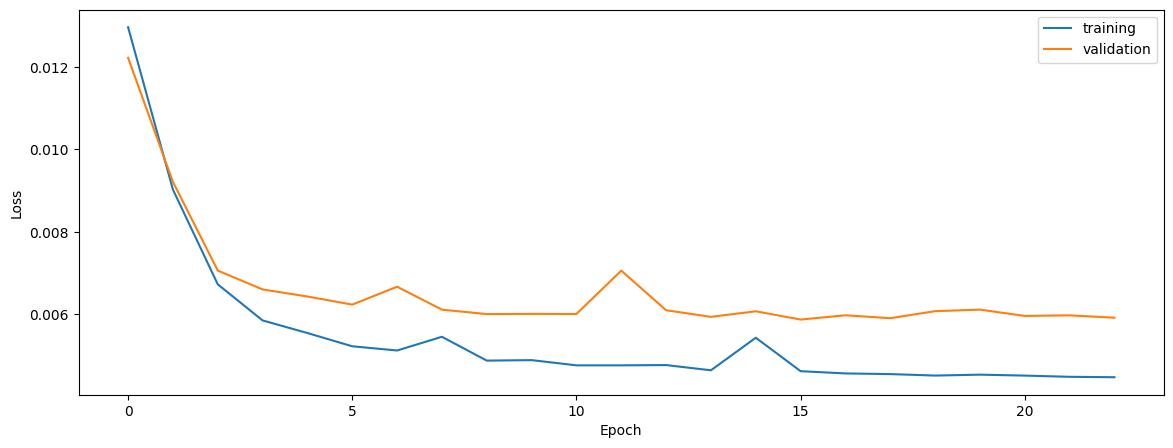

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7635560463340642
0.7293121710106991
0.639906608874147


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7635560463340642
0.7293121710106991
0.639906608874147


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7676686252270427
0.739356631149915
0.6556971529038046


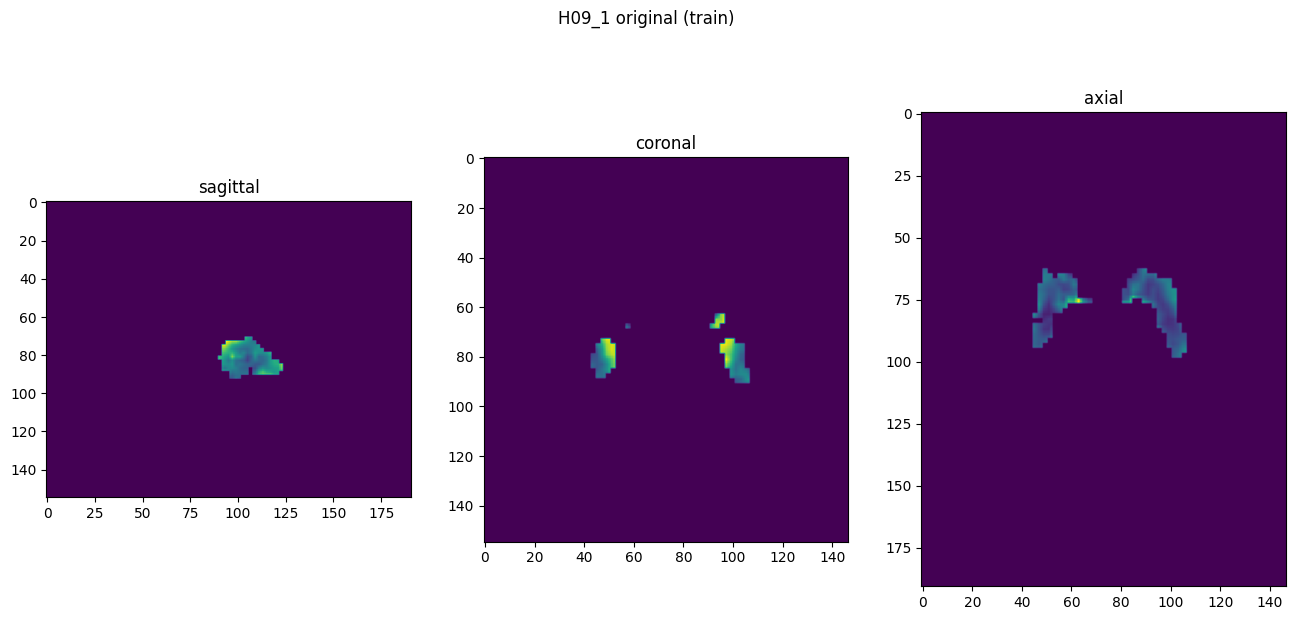

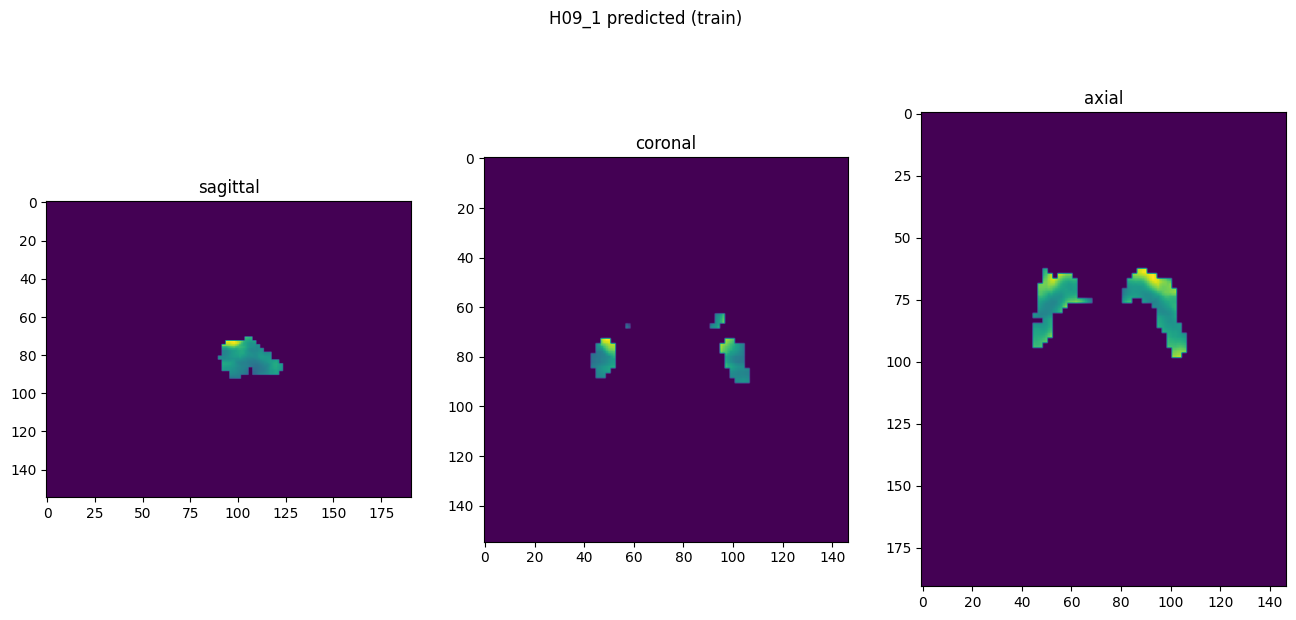

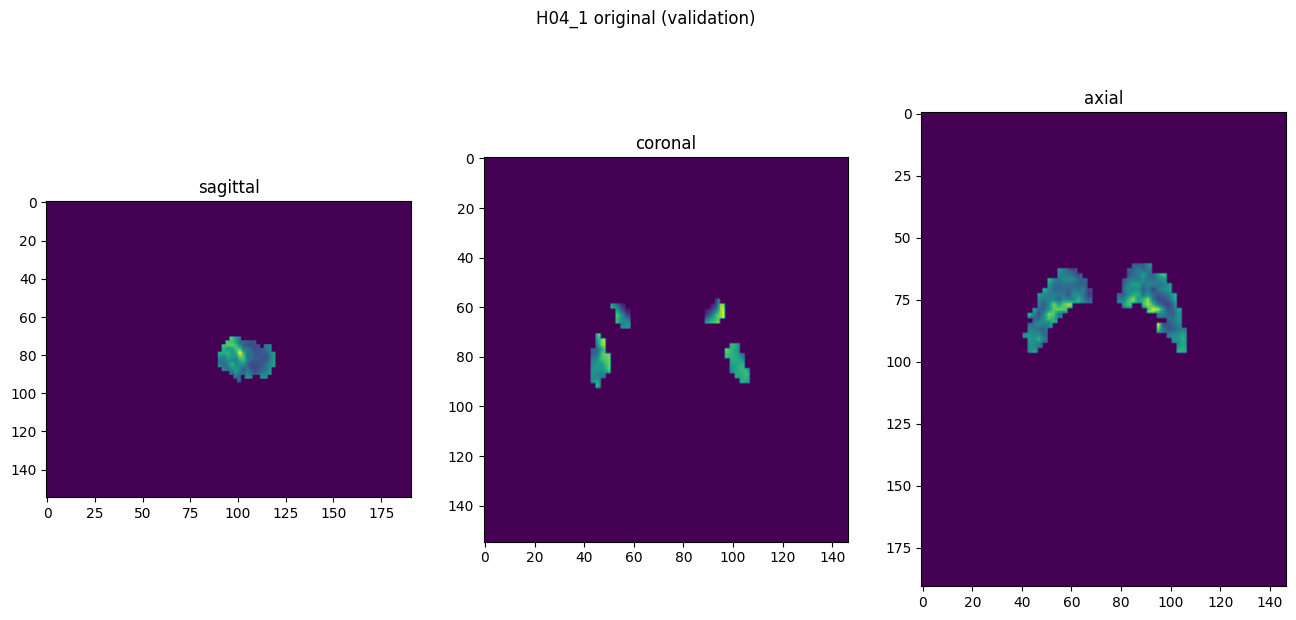

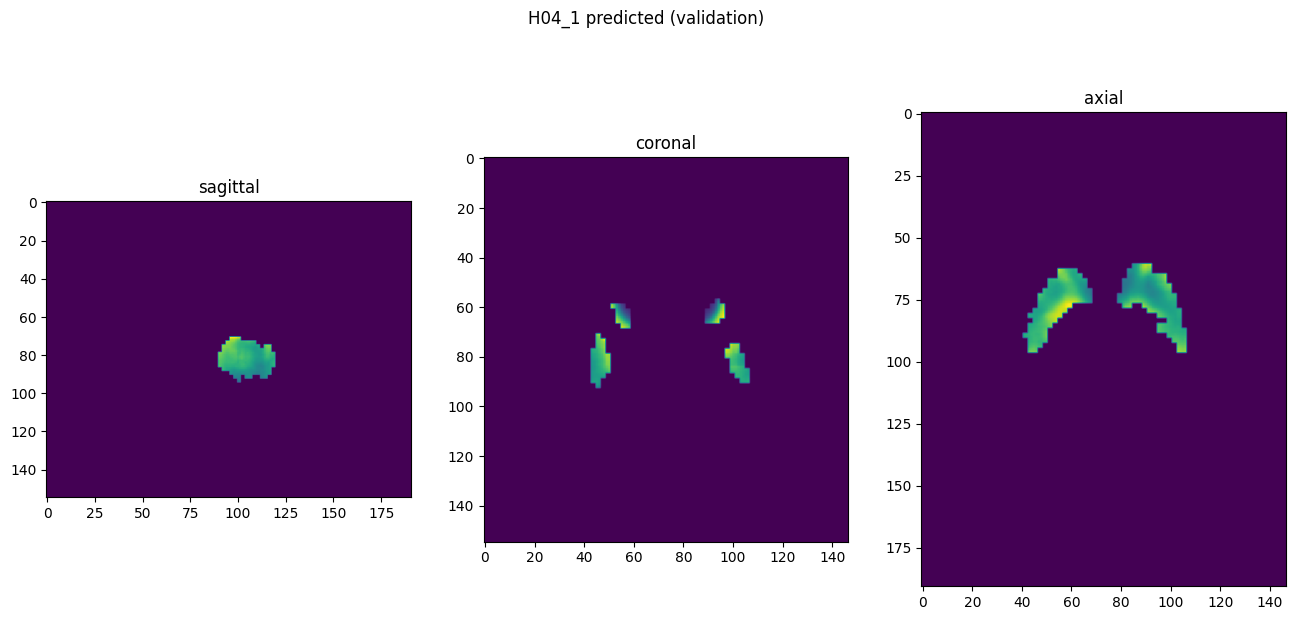

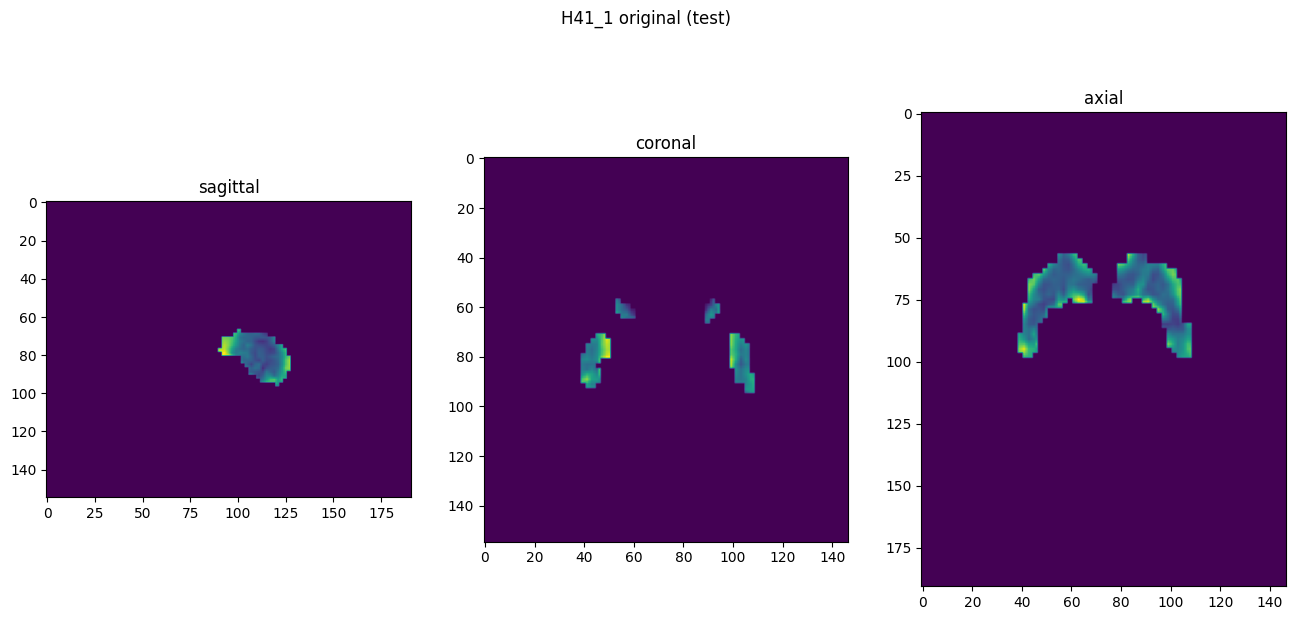

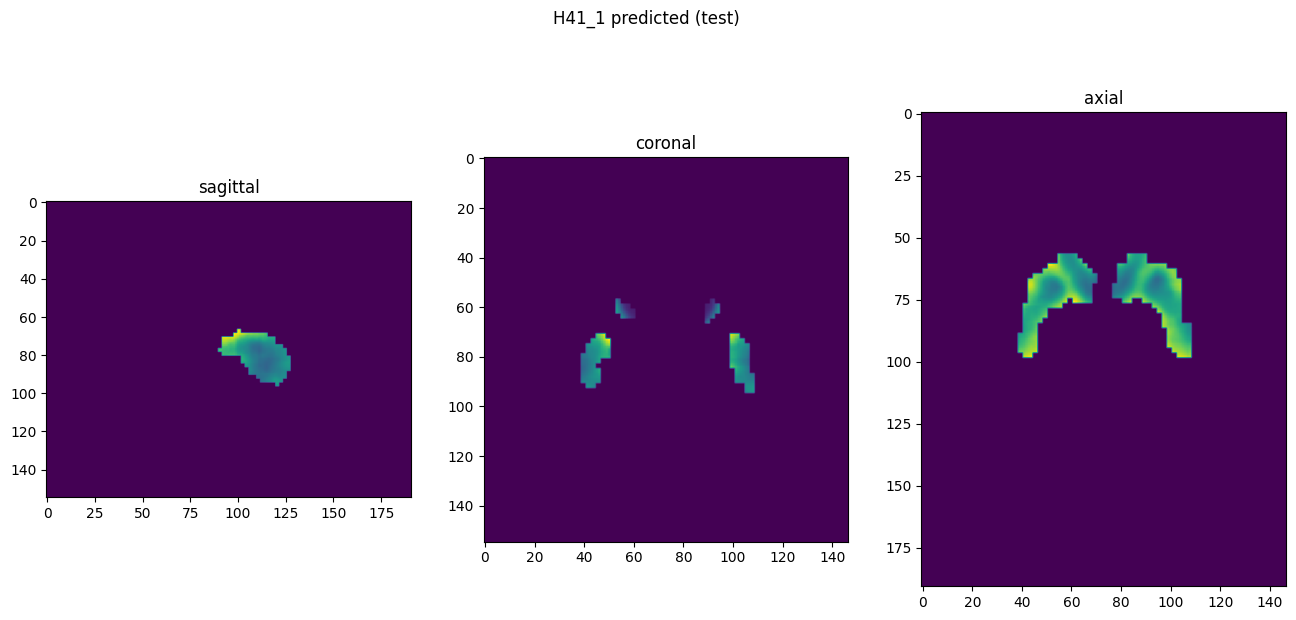

In [10]:
showResults(model, gen, threshold=None, background=False)